# Machine Learning Project - Car prices prediction #
This notebook was created for a university Machine Learning project.
The goal of the project is to train and evaluate one or more regression models to **predict the sales price of used cars**.
The project is based on a dataset containing about 40k examples of used cars sold in the UK.

## Libraries ##
I preferred to **group all the libraries** used in the project into a single cell to try to make it a little cleaner.

In [1]:
import os
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.rc("axes", titleweight = "bold", titlesize = 18, titlepad = 10)

## Load the data ##
As a first step, I created some simple **functions to load data** from the train set and the test set. The first split of the data and creation of the related files was done previously thanks to some (now commented) lines that you can find in the following cells.

In [2]:
def load_car_prices_data(path = "C:/Users/simon/Desktop/ML/dataset"):
    csv_path = os.path.join(path, "car_prices.csv")    
    return pd.read_csv(csv_path)

def load_cp_training_data(path = "C:/Users/simon/Desktop/ML/dataset"):
    csv_path = os.path.join(path, "cp_train.csv")   
    return pd.read_csv(csv_path)

def load_cp_test_data(path = "C:/Users/simon/Desktop/ML/dataset"):
    csv_path = os.path.join(path, "cp_test.csv")
    return pd.read_csv(csv_path)

## Data structure analysis ##
Then I loaded the data and took a quick look at its **structure**. To obtain the training set and the test set we could also have used another method: as can be seen from the commented lines, the *random_state* variable would have allowed us to split the data in the same way each time, making it unnecessary to split the dataset into two separate .csv files.

In [3]:
#dataset = load_car_prices_data()
#X = dataset.copy()
#y = dataset.copy().pop("price")
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

#These lines create two different files for the training set and the test set!
#X_train, X_test = train_test_split(X, test_size = 0.20, random_state = 42)
#X_train.to_csv("1cp_train.csv", index = False)
#X_test.to_csv("1cp_test.csv", index = False)

car_prices = load_cp_training_data()
test_set = load_cp_test_data()

car_prices.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Toyota,Yaris,2016,Automatic,29984,Petrol,55.0,1.3,10999
1,Audi,Q5,2016,Semi-Auto,28250,Diesel,47.1,2.0,22000
2,Audi,A5,2019,Automatic,10,Diesel,46.3,2.0,27990
3,BMW,X7,2019,Semi-Auto,1657,Diesel,31.4,3.0,73990
4,Mercedes,A Class,2020,Semi-Auto,1499,Petrol,53.3,1.3,27990


In [4]:
car_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33044 entries, 0 to 33043
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  33044 non-null  object 
 1   model         33044 non-null  object 
 2   year          33044 non-null  int64  
 3   transmission  33044 non-null  object 
 4   mileage       33044 non-null  int64  
 5   fuelType      33044 non-null  object 
 6   mpg           33044 non-null  float64
 7   engineSize    33044 non-null  float64
 8   price         33044 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.3+ MB


From this first analysis I observed that:
- there are four categorical features,
- there are five numerical features,
- there are 33044 entries and all of them are non-null values.

Next, I checked for **duplicate values**.

In [5]:
car_prices.duplicated().sum()

381

Since there were 381 duplicate values in our dataset I proceded to drop them.

In [6]:
car_prices = car_prices.drop_duplicates()
car_prices.duplicated().sum()

0

I then took a quick look at the training set's **description**.

In [7]:
car_prices.describe()

,year,mileage,mpg,engineSize,price
count,32663.000000,32663.000000,32663.000000,32663.000000,32663.000000
mean,2017.086306,23929.513425,55.756630,1.963139,21665.743441
std,2.236833,22599.069354,21.152975,0.602314,11694.530190
min,1970.000000,1.000000,1.100000,0.000000,650.000000
25%,2016.000000,6392.000000,45.600000,1.500000,13866.000000
50%,2017.000000,17771.000000,55.000000,2.000000,19599.000000
75%,2019.000000,34465.500000,64.200000,2.100000,26733.000000
max,2020.000000,323000.000000,470.800000,6.600000,154998.000000


Thanks to this description I noticed that there were something "strange" (e.g. `engineSize = 0.0`), so I decided to investigate it! I plotted the distribution of numerical values trying to identify outliers.

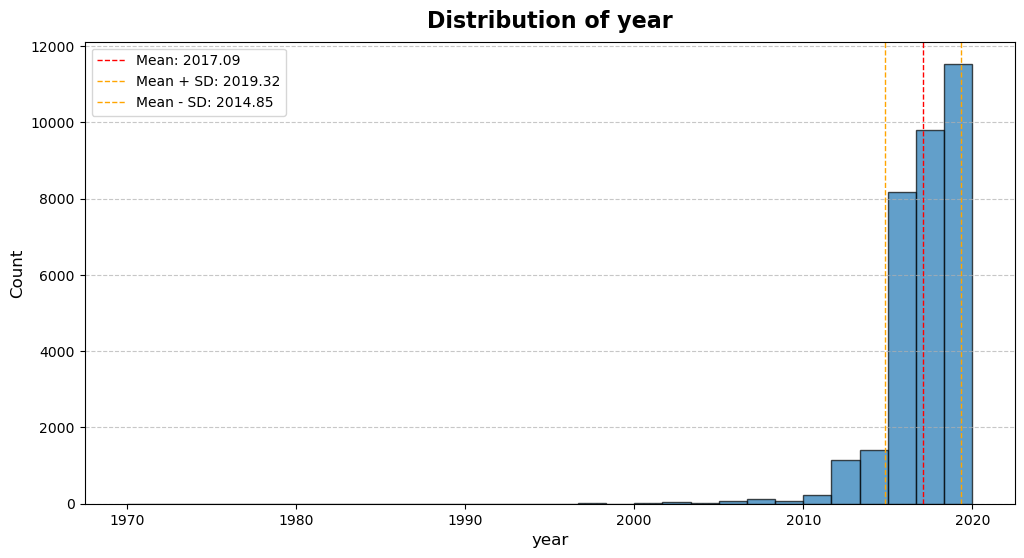

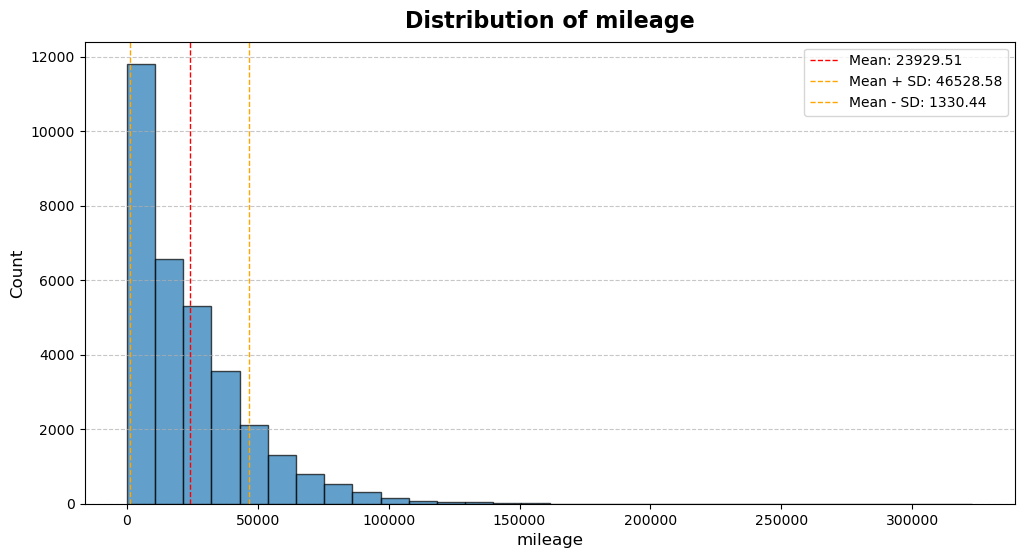

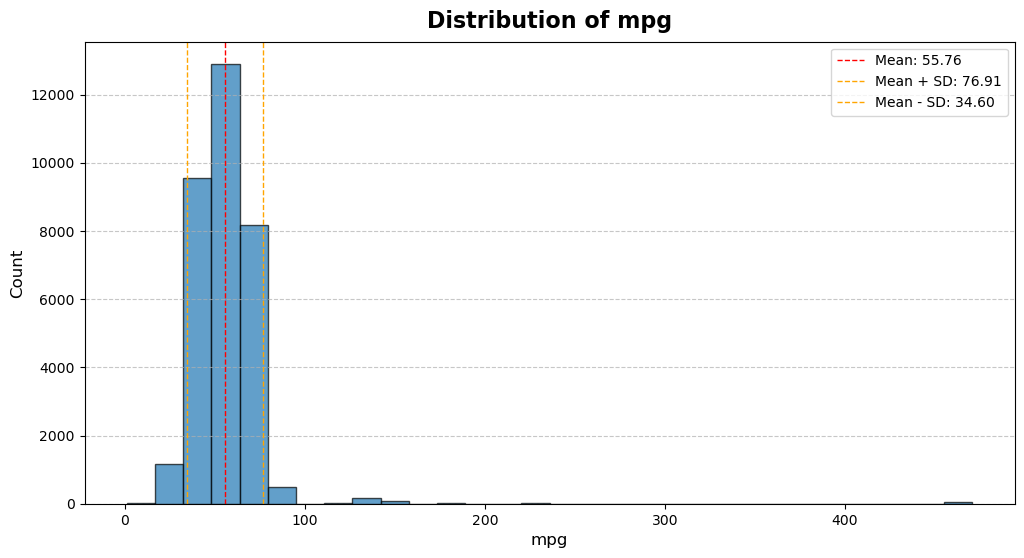

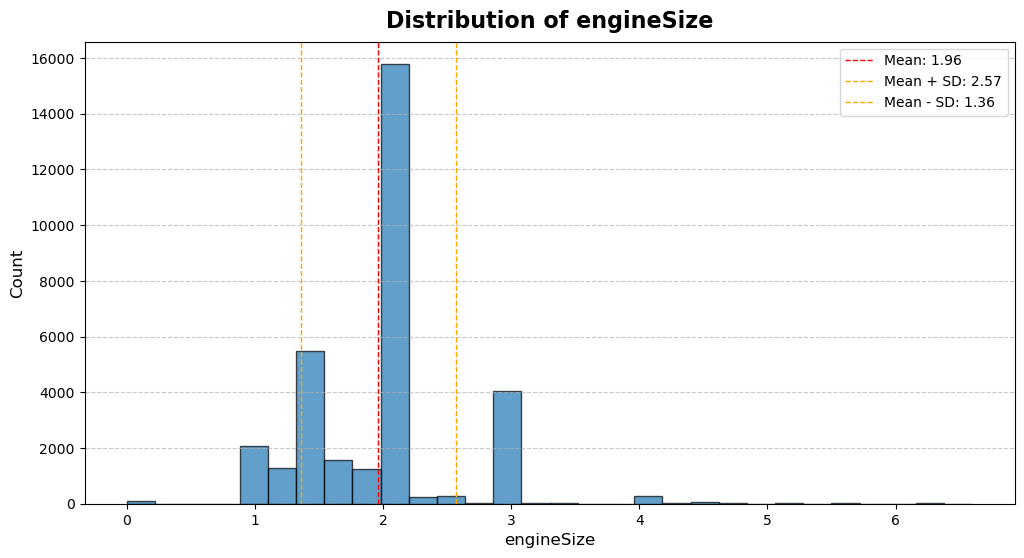

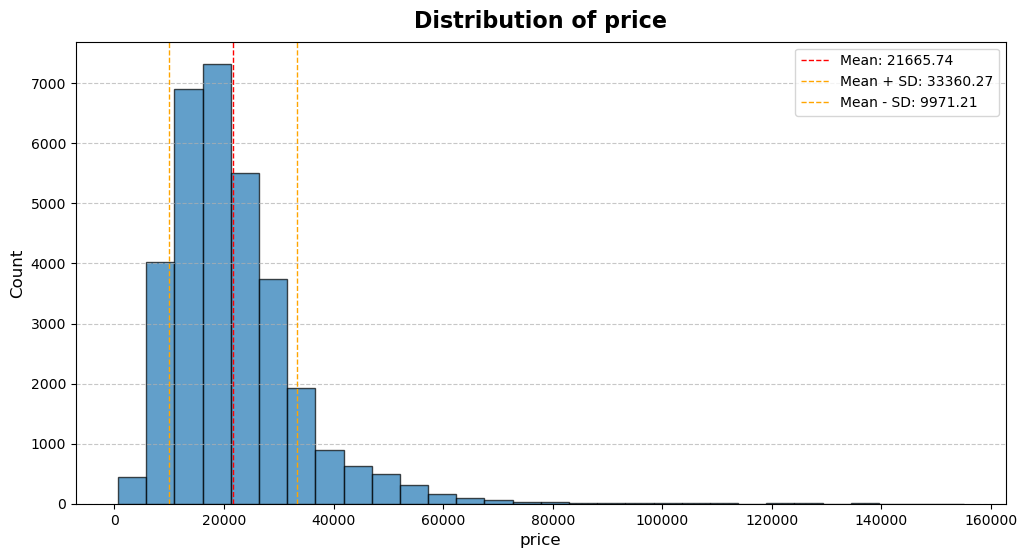

In [8]:
numerical_features = ["year", "mileage", "mpg", "engineSize", "price"]

for feature in numerical_features:
    plt.figure(figsize = (12, 6))
    
    plt.hist(car_prices[feature], bins = 30, color = "tab:blue", edgecolor = "black", alpha = 0.7)
    
    mean_value = car_prices[feature].mean()
    std_dev = car_prices[feature].std()
    
    plt.axvline(mean_value, color = "red", linestyle = "dashed", linewidth = 1, label = f"Mean: {mean_value:.2f}")
    plt.axvline(mean_value + std_dev, color = "orange", linestyle = "dashed", linewidth = 1, label = f"Mean + SD: {mean_value + std_dev:.2f}")
    plt.axvline(mean_value - std_dev, color = "orange", linestyle = "dashed", linewidth = 1, label = f"Mean - SD: {mean_value - std_dev:.2f}")
    
    plt.title(f"Distribution of {feature}", fontsize = 16)
    plt.xlabel(feature, fontsize = 12)
    plt.ylabel("Count", fontsize = 12)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
    
    plt.legend()
    plt.show()

Then, thanks to graphs and the `describe()` method, I observed that some outliers really existed! For example:
- 8 entries with `mpg` > 250
- 8 entries with `year` < 1999
- 4 entries with `mileage` > 200k
- 2 entries with `price` > 140k

so I proceeded to remove them.

In [9]:
car_prices = car_prices[car_prices["engineSize"] > 0.0]
car_prices = car_prices[car_prices["mpg"] <= 250]
car_prices = car_prices[car_prices["year"] >= 1999]
car_prices = car_prices[car_prices["mileage"] <= 200000]
car_prices = car_prices[car_prices["price"] <= 140000]

Once I ensured that there were no duplicate values, null-values and some outliers that could have created problems during the training I proceeded to **explore the categorical features** of our dataset.

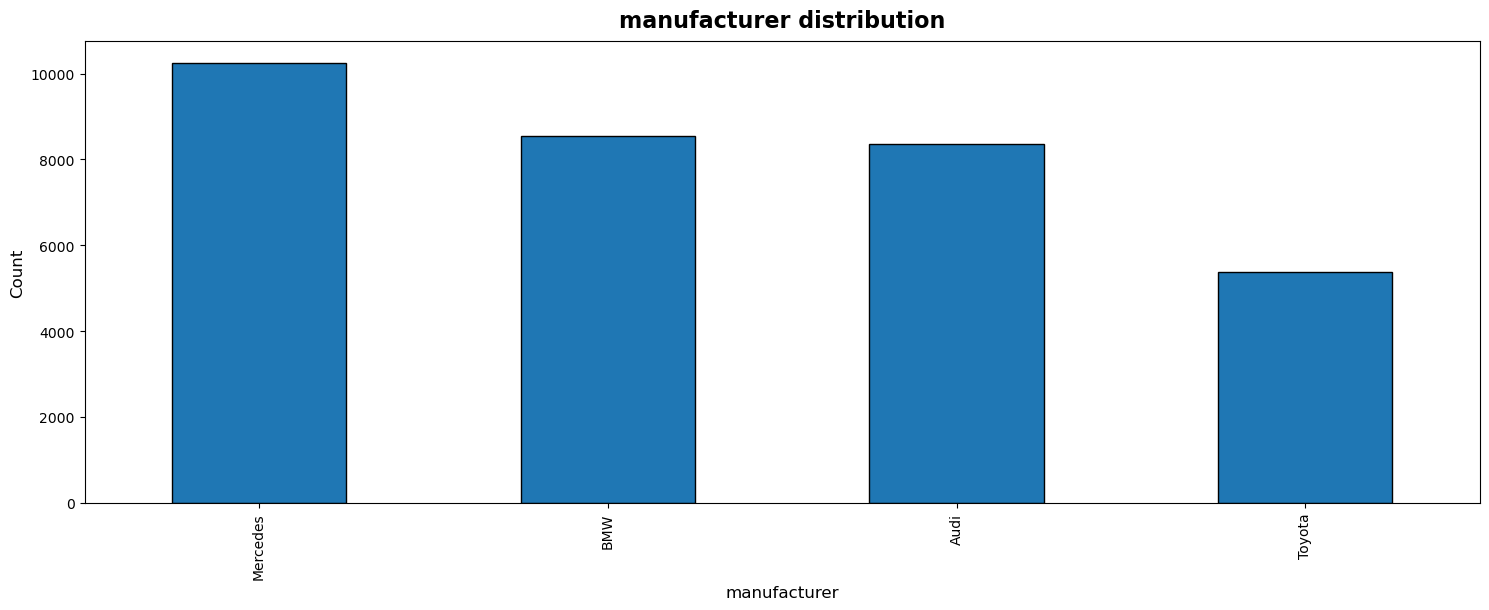

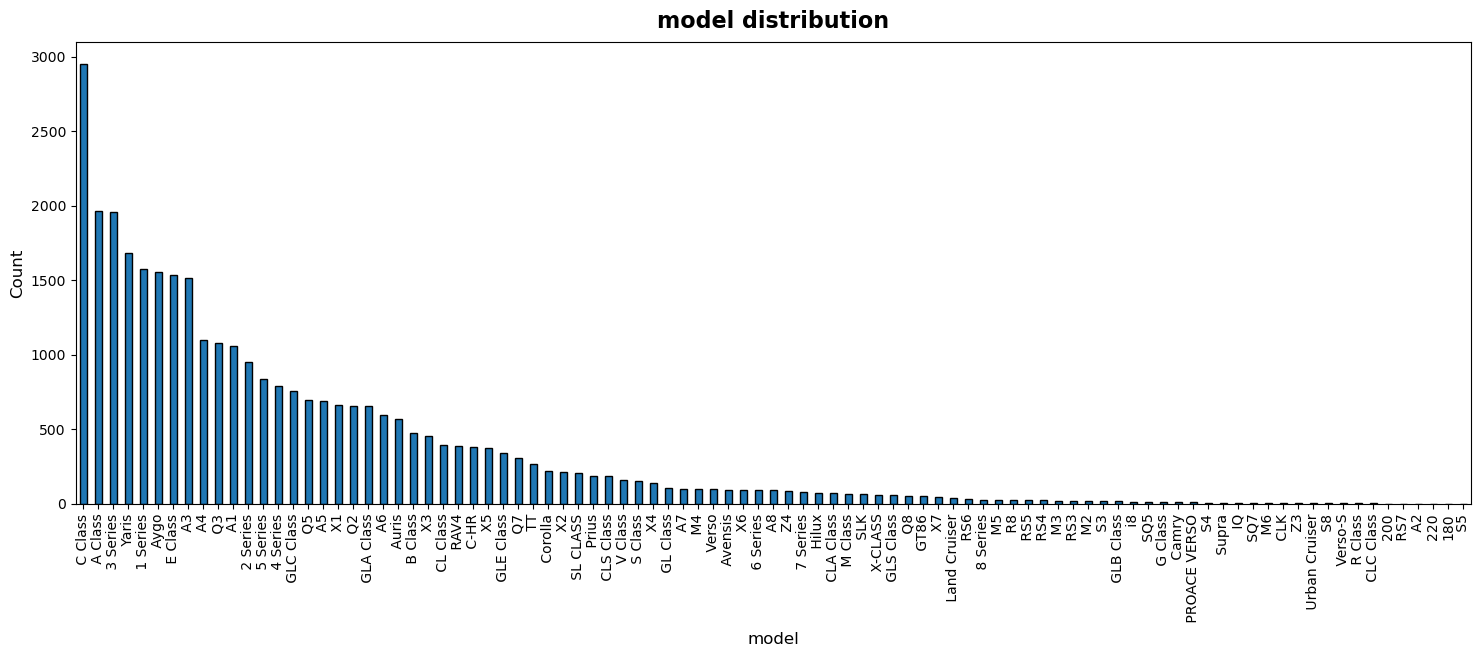

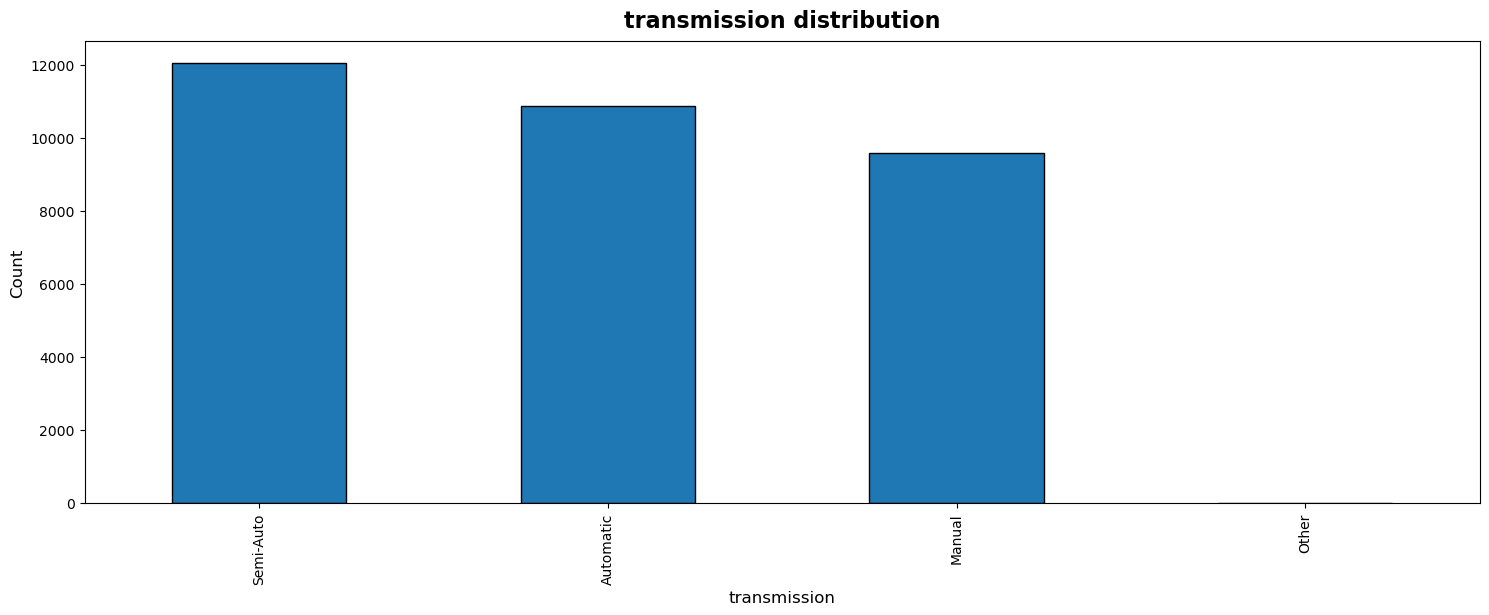

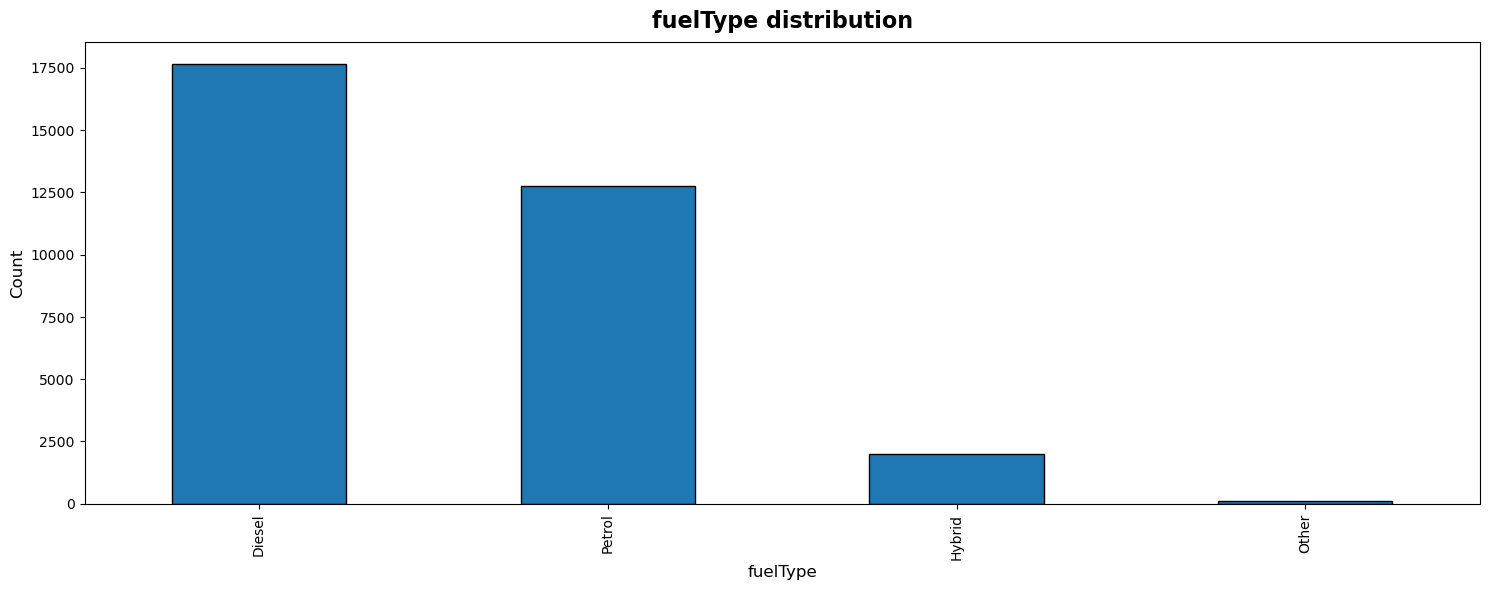

In [10]:
categorical_features = ["manufacturer", "model", "transmission", "fuelType"]

for feature in categorical_features:
    plt.figure(figsize = (18, 6))
    
    car_prices[feature].value_counts().plot(kind = "bar", color = "tab:blue", edgecolor = "black")
    
    plt.title(f"{feature} distribution", fontsize = 16)
    plt.xlabel(feature, fontsize = 12)
    plt.ylabel("Count", fontsize = 12)
    
    plt.show()

I then calculated and visualized the **correlations between the numerical features** to see if any numerical feature did not actually correlate with the car price.

<Figure size 800x600 with 0 Axes>

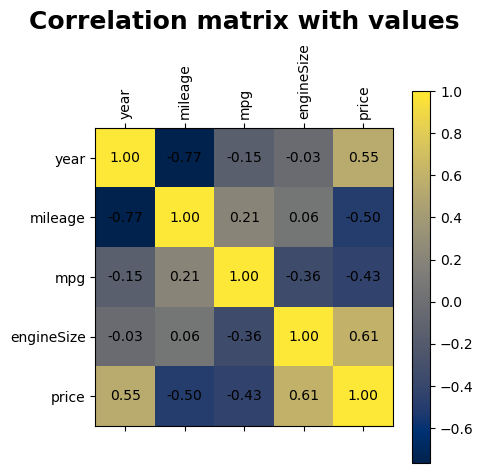

In [11]:
correlation_matrix = car_prices.corr(numeric_only = True)

plt.figure(figsize=(8, 6))

cax = plt.matshow(correlation_matrix, cmap = "cividis")
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar(cax)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha = "center", va = "center", color = "black")

plt.title("Correlation matrix with values")
plt.show()

Because of the correlation matrix, I considered every single numerical feature essential, so I did not drop any of them.

## Data preprocessing ##
I **preprocessed** our data: since there is no order (intrinsic or relevant) in the categorical features, I used the **one-hot encoder rather than a mapping**.

In [12]:
X_train = car_prices.copy()
y_train = X_train.pop("price")

X_test = test_set.copy()
y_test = X_test.pop("price")

numerical_columns = ["year", "mileage", "mpg", "engineSize"]
categorical_columns = ["manufacturer", "model", "transmission", "fuelType"]

transformer_num = make_pipeline(
    SimpleImputer(strategy = "median"),
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = "NA"),
    OneHotEncoder(handle_unknown = "ignore"),
)

preprocessor = make_column_transformer(
    (transformer_num, numerical_columns),
    (transformer_cat, categorical_columns),
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In short, `fit_transform()` is responsible for both fitting the preprocessor to the data and applying the transformations, while `transform()` only applies the transformations to the data using the parameters previously fitted during `fit_transform()`.
This is important to ensure that the same transformations are applied to both training and test sets, to maintain consistency in the preprocessed data and ensure that the model is evaluated on data with the same transformation.

## Training the model ##
After preprocessing, I tried several models to see which one performed best for our task.

### K-Nearest Neighbor ###
As first model I used the KNN model and the **GridSearchCV** to see how the model performed as the *K* hyperparameter changed in order to get the best one. The best *n_neighbors* value turned out to be 5. Once found, I commented out the lines related to GridSearchCV in order to speed up hypothetical retraining.

In [13]:
#param_grid = {"n_neighbors": [3, 5, 7, 9]}

#knn_model = KNeighborsRegressor()

#grid_search = GridSearchCV(estimator = knn_model, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = 5)
#grid_search.fit(X_train, y_train)

#best_params = grid_search.best_params_
#print("Best K value: ", best_params["n_neighbors"])

#best_knn_model = grid_search.best_estimator_
#best_knn_predictions = best_knn_model.predict(X_test)
#best_knn_rmse = mean_squared_error(y_test, best_knn_predictions, squared = False)

#print("Best KNN model Root Mean Squared Error (RMSE): ", best_knn_rmse)

start_time_knn = time.time()

knn_model = KNeighborsRegressor(n_neighbors = 5)

knn_model.fit(X_train, y_train)

knn_predictions = knn_model.predict(X_test)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared = False)

end_time_knn = time.time()
time_knn = end_time_knn - start_time_knn

print("KNN model Root Mean Squared Error (RMSE): ", knn_rmse)

KNN model Root Mean Squared Error (RMSE):  2676.433119252201


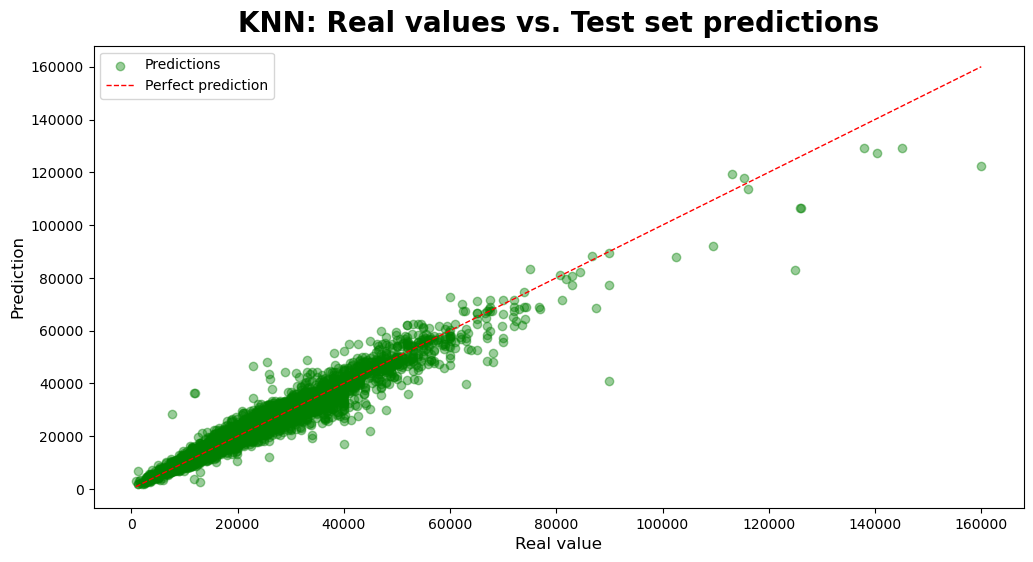

In [14]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, knn_predictions, color = "green", label = "Predictions", alpha = 0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = "--", color = "red", linewidth = 1, label = "Perfect prediction")

plt.title("KNN: Real values vs. Test set predictions", fontsize = 20)
plt.xlabel("Real value", fontsize = 12)
plt.ylabel("Prediction", fontsize = 12)

plt.legend()
plt.show()

### Linear regression ###

In [15]:
lr_model = LinearRegression()

start_time_lr = time.time()

lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

end_time_lr = time.time()
time_lr = end_time_lr - start_time_lr

lr_rmse = mean_squared_error(y_test, lr_predictions, squared = False)
print("Linear Regression  Root Mean Squared Error (RMSE) : ", lr_rmse)

Linear Regression  Root Mean Squared Error (RMSE) :  5019.470196050192


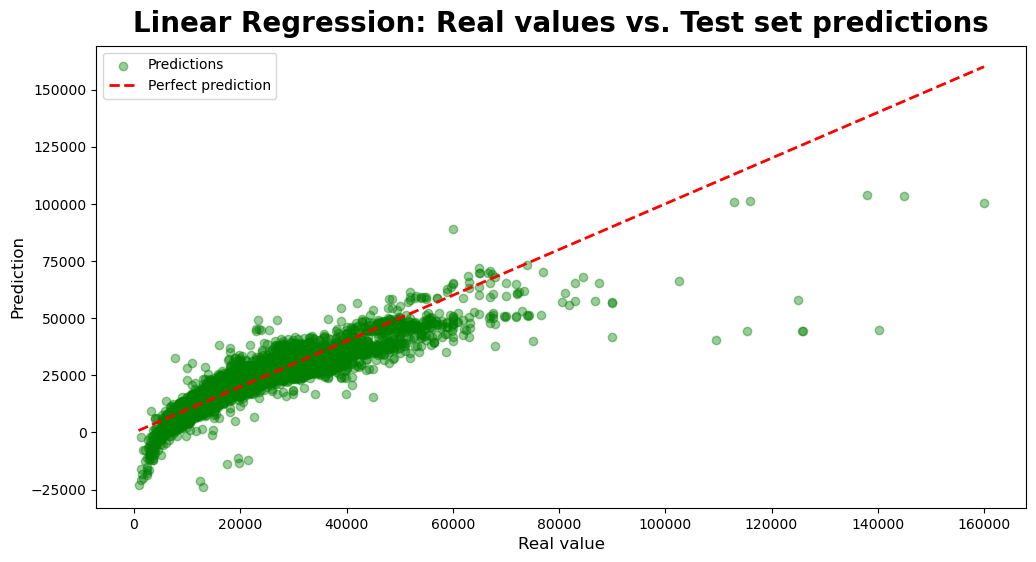

In [16]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, lr_predictions, color = "green",  label = "Predictions", alpha = 0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = "--", color = "red", linewidth = 2,  label = "Perfect prediction")

plt.title("Linear Regression: Real values vs. Test set predictions", fontsize = 20)
plt.xlabel("Real value", fontsize = 12)
plt.ylabel("Prediction", fontsize = 12)

plt.legend()
plt.show()

### Decision tree ###

In [17]:
dt_model = DecisionTreeRegressor(random_state = 42)

start_time_dt = time.time()

dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

end_time_dt = time.time()
time_dt = end_time_dt - start_time_dt

dt_rmse = mean_squared_error(y_test, dt_predictions, squared = False)
print("Decision Tree Root Mean Squared Error (RMSE): ", dt_rmse)

Decision Tree Root Mean Squared Error (RMSE):  2848.676781859721


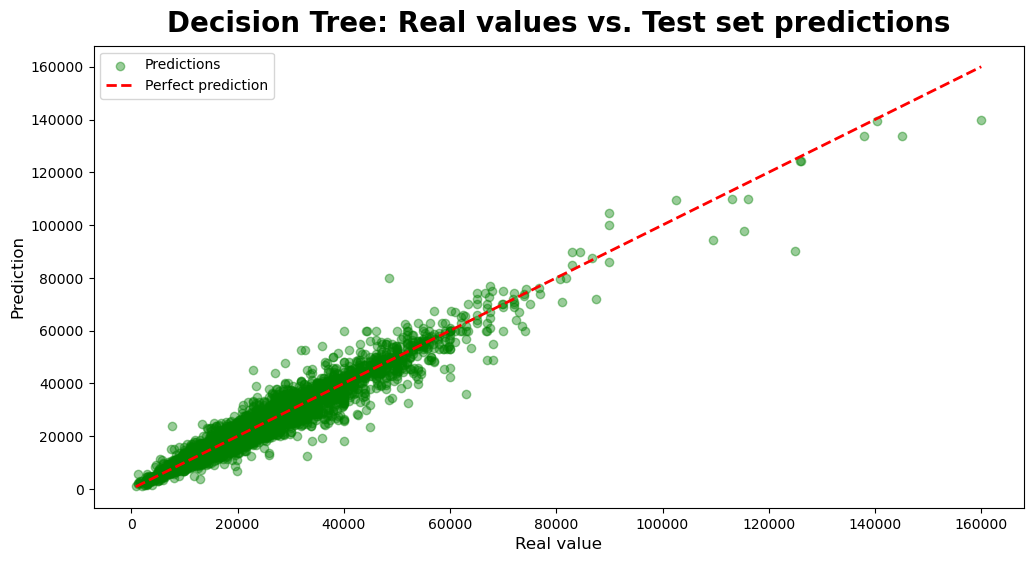

In [18]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, dt_predictions, color = "green",  label = "Predictions", alpha = 0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = "--", color = "red", linewidth = 2,  label = "Perfect prediction")

plt.title("Decision Tree: Real values vs. Test set predictions", fontsize = 20)
plt.xlabel("Real value", fontsize = 12)
plt.ylabel("Prediction", fontsize = 12)

plt.legend()
plt.show()

### Random forest ###
In addition to the KNN model, I also used **GridSearchCV** in the Random Forest model: the best value of the hyperparameter *n_estimators* turned out to be 300. Once found, I commented out the lines related to GridSearchCV in order to speed up hypothetical retraining.

In [19]:
#rf_model = RandomForestRegressor()

#param_grid = {
#    "n_estimators": [50, 100, 150, 200, 250, 300]
#}

#grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = 5)
#grid_search.fit(X_train, y_train)

#best_params = grid_search.best_params_
#print("Best estimators number: ", best_params["n_estimators"])

#best_rf_model = grid_search.best_estimator_
#rf_predictions = best_rf_model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators = 300)
 
start_time_rf = time.time()

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = metrics.mean_squared_error(y_test, rf_predictions, squared = False)

end_time_rf = time.time()
time_rf = end_time_rf - start_time_rf

print("Random Forest Root Mean Squared Error (RMSE): ", rf_rmse)

Random Forest Root Mean Squared Error (RMSE):  2362.876036002967


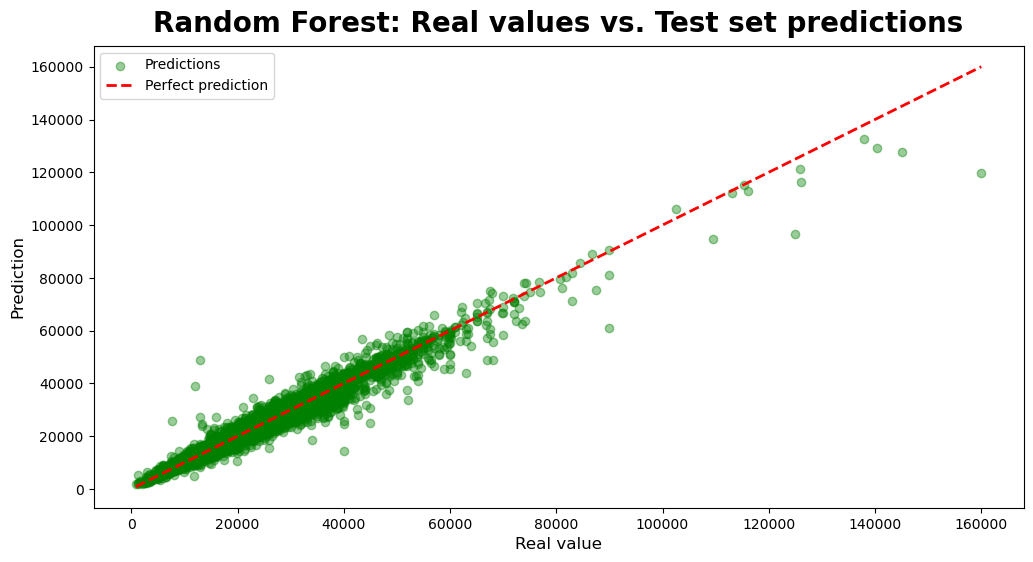

In [20]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, rf_predictions, color = "green",  label = "Predictions", alpha = 0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = "--", color = "red", linewidth = 2,  label = "Perfect prediction")

plt.title("Random Forest: Real values vs. Test set predictions", fontsize = 20)
plt.xlabel("Real value", fontsize = 12)
plt.ylabel("Prediction", fontsize = 12)

plt.legend()
plt.show()

### Neural Network ###

In [28]:
model = keras.Sequential([
    layers.Dense(64, activation = "relu", input_shape = (X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1)
])

model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mse"])

early_stopping = EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

start_time_nn = time.time()

history = model.fit(X_train_dense, y_train, epochs = 200, batch_size = 128, validation_split = 0.2, callbacks = [early_stopping], verbose = 0)
nn_predictions = model.predict(X_test_dense)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

# verbose = 0 to NOT view
nn_rmse = np.sqrt(model.evaluate(X_test_dense, y_test, verbose = 0)[1])
print(f"Neural Network RMSE on Test Set: {nn_rmse}")

259/259 [==============================] - 1s 2ms/step
Neural Network RMSE on Test Set: 2615.2100298064015


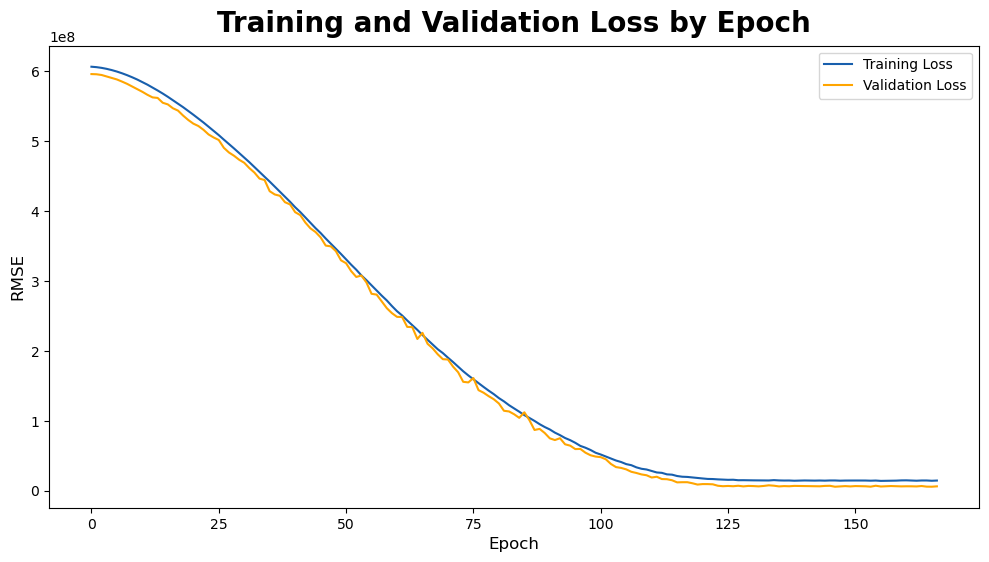

In [29]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize = (12, 6))

plt.plot(train_loss, label = "Training Loss", color = "#185fad")
plt.plot(val_loss, label = "Validation Loss", color = "orange")

plt.title("Training and Validation Loss by Epoch", fontsize = 20)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("RMSE", fontsize = 12)

plt.legend()
plt.show()

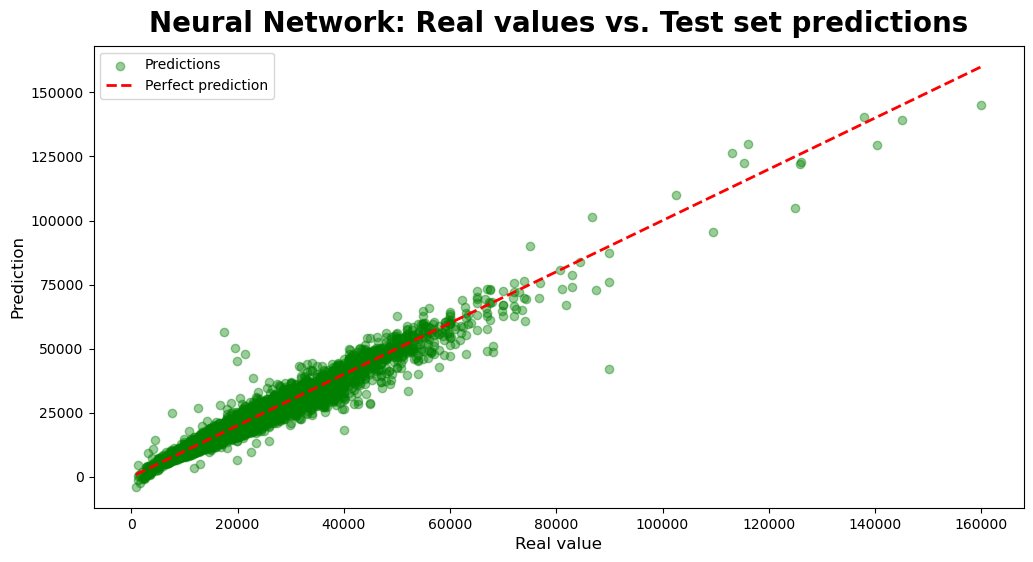

In [30]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, nn_predictions, color = "green", label = "Predictions", alpha = 0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = "--", color = "red", linewidth = 2, label = "Perfect prediction")

plt.title("Neural Network: Real values vs. Test set predictions", fontsize = 20)
plt.xlabel("Real value", fontsize = 12)
plt.ylabel("Prediction", fontsize = 12)

plt.legend()
plt.show()

## Models comparison and conclusions ##
To conclude, I **compared the performance** of the different regression models. For each model, I calculated the **RMSE** to evaluate the accuracy of the predictions on the test set and considered the **processing time** for each model to evaluate its computational efficiency.

In [31]:
models = ["KNN", "Linear Regression", "Decision Tree", "Random Forest", "Neural Network"]
rmse_values = [knn_rmse, lr_rmse, dt_rmse, rf_rmse, nn_rmse]
processing_times = [time_knn, time_lr, time_dt, time_rf, time_nn]

results_data = {
    "Model": models,
    "RMSE": rmse_values,
    "Processing Time (s)": processing_times,
}

results_df = pd.DataFrame(results_data)

print("Results\n")
for index, row in results_df.iterrows():
    print(f"{row['Model']:20} | RMSE: {row['RMSE']:.4f} | Processing Time: {row['Processing Time (s)']:.2f} seconds")

Results

KNN                  | RMSE: 2676.4331 | Processing Time: 4.33 seconds
Linear Regression    | RMSE: 5019.4702 | Processing Time: 0.27 seconds
Decision Tree        | RMSE: 2848.6768 | Processing Time: 2.16 seconds
Random Forest        | RMSE: 2362.8760 | Processing Time: 435.94 seconds
Neural Network       | RMSE: 2615.2100 | Processing Time: 130.92 seconds


Finally, I also **visually compared the model predictions** with the actual values via graphs.
The results indicated that the **Random Forest model performed the best in terms of prediction accuracy**, while the **Linear Regression model was the most computationally efficient**.

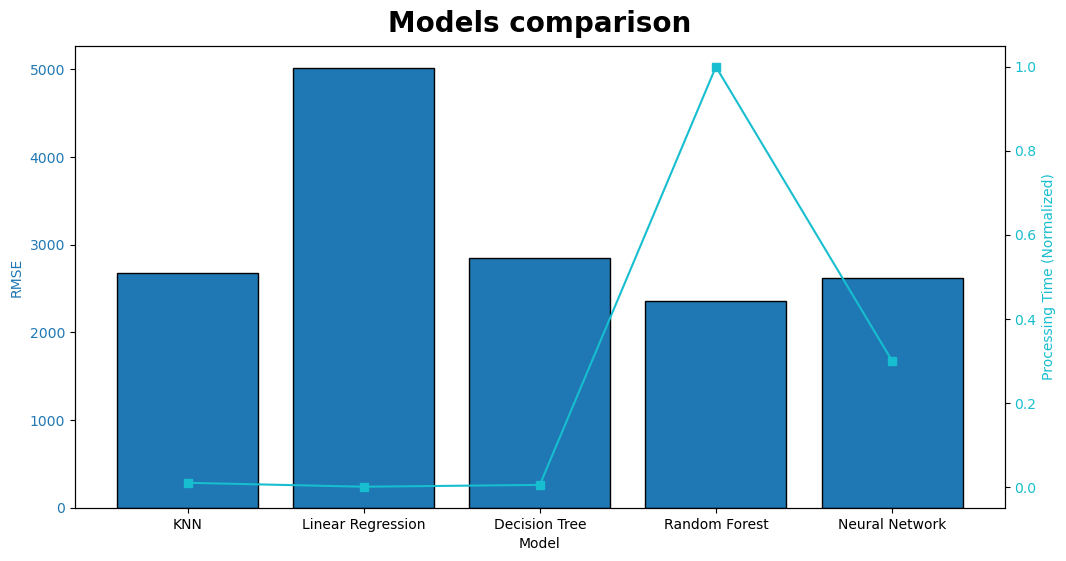

In [32]:
# I normalized the processing times for better visualization
max_time = max(processing_times)
normalized_processing_times = [time / max_time for time in processing_times]

fig, ax1 = plt.subplots(figsize = (12, 6))

# RMSE axes
color = "tab:blue"
ax1.set_xlabel("Model")
ax1.set_ylabel("RMSE", color = color)
ax1.bar(models, rmse_values, color = color, edgecolor = "black")
ax1.tick_params(axis = "y", labelcolor = color)

# Processing time axes
ax2 = ax1.twinx()
color = "tab:cyan"
ax2.set_ylabel("Processing Time (Normalized)", color = color)
ax2.plot(models, normalized_processing_times, color = color, marker = "s")
ax2.tick_params(axis = "y", labelcolor = color)

plt.title("Models comparison", fontsize = 20)
plt.show()